In [1]:
%matplotlib inline


# Generate Design Matrix


Here we generate the design matrix for a NIRS measurement

In [9]:
import mne
import os.path as op
from mne.preprocessing import nirs
from mne.io import read_raw_nirx

fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = op.join(fnirs_data_folder, 'Participant-1')
raw = read_raw_nirx(fnirs_raw_dir)
raw = nirs.optical_density(raw)
raw = nirs.beer_lambert_law(raw)
raw = raw.pick(picks=[0])

Loading /Users/rluke/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


In [10]:
def create_design_matrix(raw, event_id=None, stim_dur=5):
    from scipy import signal
    from bids.analysis import hrf
    bc = signal.boxcar(round(raw.info['sfreq']*stim_dur))
    events, ids = mne.events_from_annotations(raw, event_id=event_id)
    s = np.zeros((len(raw.times), len(ids)))
    h0 = hrf._gamma_difference_hrf(raw.info['sfreq'], time_length = 32, delay=4)
    for idx, id in enumerate(ids):
        id_idx = [e[2] == idx+1 for e in events]  
        id_evt = events[id_idx]   
        event_samples = [e[0] for e in id_evt]
        s[event_samples, idx] = 1.
        s[:, idx] = np.convolve(s[:, idx], bc)[:len(raw.times)]
        s[:, idx] = np.convolve(s[:, idx], h0)[:len(raw.times)]
    return s

Used Annotations descriptions: ['1.0', '15.0', '2.0', '3.0']


(0.0, 3000.0)

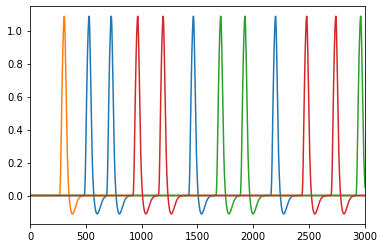

In [11]:
import matplotlib.pyplot as plt
import numpy as np

s = create_design_matrix(raw)
plt.plot(s)
plt.xlim(0, 3000)